In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import numpy as np
import joblib
import sys
import imodels
import notebook_helper
import imodelsx.process_results
sys.path.append('../experiments/')
results_dir = '../results/ensemble/'

r = imodelsx.process_results.get_results_df(results_dir)
experiment_filename = '../experiments/01_train_model.py'
r = imodelsx.process_results.fill_missing_args_with_default(r, experiment_filename)
# r.to_pickle('../results/agg.pkl')
# imodelsx.process_results.delete_runs_in_dataframe(r[r.use_bagging_ensemble == 1], actually_delete=True)

100%|██████████| 148/148 [00:00<00:00, 4007.65it/s]


In [2]:
ravg = notebook_helper.get_ravg_with_stability(r)

100%|██████████| 50/50 [00:00<00:00, 145.65it/s]


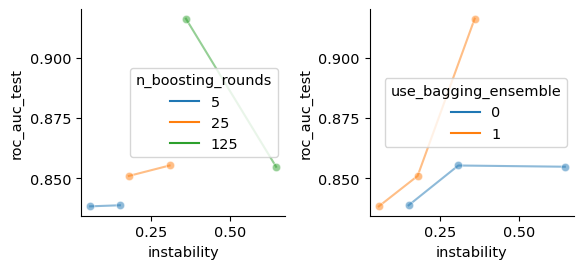

In [7]:
group_keys = [
    k
    for k in imodelsx.process_results.get_main_args_list(
        experiment_filename="01_train_model.py"
    )
    if not k == "seed"
]

df = pd.DataFrame(ravg)
df = (
    df.groupby([k for k in group_keys if not k == "dataset_name"])[
        ["roc_auc_test", "instability"]
    ]
    .mean()
    .reset_index()
)
# df = df[~((df.n_boosting_rounds == 0) & (df.n_boosting_rounds_marginal == 0))]
df = df[df.roc_auc_test >= 0.8]
# df = df[df.boosting_strategy == 'cyclic']
# df = df[df.fit_linear_marginal == "None"]
# df = df[df.n_boosting_rounds == 0]
# df = df[df.n_boosting_rounds_marginal == 5]
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

kwargs = dict(
    data=df,
    x="instability",
    y="roc_auc_test",
    palette="tab10",
    alpha=0.5,
)
ks = [
    "n_boosting_rounds",
    'use_bagging_ensemble'
]
for i, k in enumerate(ks):
    ax = axes.flatten()[i]
    sns.lineplot(
        **kwargs,
        hue=k,
        ax=ax,
        marker='o'
    )
    ax.legend(fontsize="x-small", title=k, title_fontsize="x-small")
    # make all fontsizes small
    for item in (
        [ax.title, ax.xaxis.label, ax.yaxis.label]
        + ax.get_xticklabels()
        + ax.get_yticklabels()
    ):
        item.set_fontsize("x-small")

plt.show()

In [10]:
for val in ['roc_auc_test', 'instability']:
    print(val)
    df = pd.DataFrame(ravg)
    df['reg_param'] = df['reg_param'].astype(str)
    df['reg_param_marginal'] = df['reg_param_marginal'].astype(str)
    means = df.pivot_table(
        index=["boosting_strategy", "n_boosting_rounds", "reg_param"],
        columns=["n_boosting_rounds_marginal", "reg_param_marginal"],
        values=[val],
        aggfunc="mean",
    )
    # replace values <=0.5 with nan
    if val == 'roc_auc_test':
        means[means <= 0.5] = np.nan
    else:
        means[means >= 0.5] = np.nan

    display(means.style.format(precision=2).background_gradient(cmap="RdBu_r", axis=None))

roc_auc_test


instability
